In [16]:
# If it's a fresh environment:
# !pip install jax jax-sysid matplotlib -q

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

import jax
import jax.numpy as jnp
from jax import config as jax_config

from jax_sysid.models import Model
from jax_sysid.utils import standard_scale, unscale, compute_scores

jax_config.update("jax_enable_x64", True)  # keep double precision (optional but nice)


## Physical Config + functions

In [17]:
# =========================
# Index map
# =========================
IDX = {
    "cn": slice(0,4),
    "cp": slice(4,8),
    "ce": slice(8,14),
    "cn_surf": 3,
    "cp_surf": 7,
    "ce_left": 8,
    "ce_right": 13,
}

# =========================
# Config 
# =========================
@dataclass
class Config:
    R: float = 8.314462618
    F: float = 96485.33212
    T: float = 298.15
    T_ref: float = 298.15

    L1: float = 25e-6
    L2: float = 20e-6
    L3: float = 25e-6
    Rn: float = 5e-6
    Rp: float = 5e-6
    A:  float = 1.0

    Dn: float = 1e-14
    Dp: float = 1e-14
    De: float = 7.23e-10
    eps: float = 0.30

    kappa_n_eff: float = 1.0
    kappa_s_eff: float = 1.0
    kappa_p_eff: float = 1.0

    a_s_n: float = 1.0e6
    a_s_p: float = 1.0e6
    k_n0: float = 2.0e-11
    k_p0: float = 2.0e-11
    use_arrhenius: bool = False
    Ea_n: float = 0.0
    Ea_p: float = 0.0

    lam_n: float = 0.0
    lam_p: float = 0.0

    csn_max: float = 3.1e4
    csp_max: float = 3.1e4

    ce0: float = 1000.0
    t_plus: float = 0.38
    k_f: float = 1.0
    R_ohm: float = 0.0
    use_dynamic_film: bool = False
    Rf: float = 0.0
    L_sei: float = 0.0
    kappa_sei: float = 1.0

    ce_is_deviation: bool = True
    discharge_positive: bool = True
    ln_orientation: str = "right_over_left"
    eta_mode: str = "diff"

    I_dyn: float = 2.0
    I_for_voltage: float = 2.0

    N_series: int = 3
    T_end: float = 5000.0

    voltage_mode: str = "convex"
    use_R_ramp: bool = True
    R_ramp_start: float = 0.0
    R_ramp_end: float = 1.0
    convex_family: str = "power"
    convex_power: float = 0.5
    convex_tau: float = 500.0
    concave_family: str = "power"
    concave_power: float = 3.0
    concave_tau: float = 3000.0
    ramp_shape: str = "power"
    ramp_power: float = 3.0
    ramp_tau: float = 1800.0
    use_R_soc: bool = False
    R_soc_gain: float = 0.2
    R_soc_alpha: float = 2.0

    theta_guard: float = 1e-3
    I0_floor_p: float = 1e-2
    I0_floor_n: float = 1e-2
    bv_scale: float = 0.7
    
    
# simple IC helper
def make_x0(cfg: Config, theta_n0=0.2, theta_p0=0.9, ce0=0.0):
    x0 = np.zeros(14)
    x0[IDX["cn"]] = theta_n0 * cfg.csn_max
    x0[IDX["cp"]] = theta_p0 * cfg.csp_max
    x0[IDX["ce"]] = ce0
    return x0

def electrolyte_resistance(cfg: Config) -> float:
    return (cfg.L1/cfg.kappa_n_eff + 2.0*cfg.L2/cfg.kappa_s_eff + cfg.L3/cfg.kappa_p_eff) / (2.0*cfg.A)

def film_resistance(cfg: Config) -> float:
    if cfg.use_dynamic_film and cfg.L_sei > 0.0:
        return cfg.L_sei / (cfg.kappa_sei * cfg.a_s_n * cfg.A * cfg.L1)
    return cfg.Rf

def theta_from_cfg(cfg: Config) -> np.ndarray:
    K = 1.0
    # θ1..θ7
    t1 = K*cfg.Dn/(cfg.Rn**2)
    t2 = K*cfg.Dp/(cfg.Rp**2)
    Ke = cfg.De/cfg.eps
    t3 = K*Ke*4.0/(cfg.L1**2)
    t4 = K*Ke*16.0/((cfg.L1+cfg.L2)**2)
    t5 = K*Ke*4.0/(cfg.L2**2)
    t6 = K*Ke*16.0/((cfg.L2+cfg.L3)**2)
    t7 = K*Ke*4.0/(cfg.L3**2)
    # θ8..θ11
    sign_n = -1.0 if cfg.discharge_positive else +1.0
    sign_p = +1.0 if cfg.discharge_positive else -1.0
    t8  = sign_n * (6.0/cfg.Rn) * 1.0/(cfg.F*cfg.a_s_n*cfg.A*cfg.L1)
    t9  = sign_p * (6.0/cfg.Rp) * 1.0/(cfg.F*cfg.a_s_p*cfg.A*cfg.L3)
    t10 = sign_n * (1.0-cfg.t_plus)/(cfg.F*cfg.A*cfg.L1*cfg.eps)
    t11 = sign_p * (1.0-cfg.t_plus)/(cfg.F*cfg.A*cfg.L3*cfg.eps)
    # θ12..θ19 (OCV surrogates)
    t12, t13, t14, t15 = 4.0, -0.2, 0.60, 0.08
    t16, t17, t18, t19 = 0.10, 0.8, 0.50, 0.04
    # θ20..θ24 (BV, log, ohmic)
    t20, t21 = 50.0, 50.0
    t22 = (2*cfg.R*cfg.T/cfg.F)*(1.0-cfg.t_plus)*cfg.k_f
    base_R = cfg.R_ohm + electrolyte_resistance(cfg) + film_resistance(cfg)
    t23 = base_R
    t24 = (2*cfg.R*cfg.T/cfg.F)
    return np.array([t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,
                     t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24], dtype=float)


def unpack_theta(theta: np.ndarray):
    assert len(theta) == 24
    return {f"t{i}": theta[i-1] for i in range(1,25)}

def AB_from_theta_np(theta: np.ndarray):
    th = unpack_theta(theta)
    A = np.zeros((14,14))
    # anode block
    A[0,0]=th["t1"]; A[0,1]=th["t1"]
    A[1,0]=th["t1"]; A[1,1]=th["t1"]; A[1,2]=th["t1"]
    A[2,1]=th["t1"]; A[2,2]=th["t1"]; A[2,3]=th["t1"]
    A[3,2]=th["t1"]; A[3,3]=th["t1"]
    # cathode block
    A[4,4]=th["t2"]; A[4,5]=th["t2"]
    A[5,4]=th["t2"]; A[5,5]=th["t2"]; A[5,6]=th["t2"]
    A[6,5]=th["t2"]; A[6,6]=th["t2"]; A[6,7]=th["t2"]
    A[7,6]=th["t2"]; A[7,7]=th["t2"]
    # electrolyte
    A[8,8]  = th["t3"];              A[8,9]  = th["t3"]
    A[9,8]  = th["t3"];              A[9,9]  = th["t3"]+th["t4"];  A[9,10] = th["t4"]
    A[10,9] = th["t4"];              A[10,10]= th["t4"]+th["t5"];  A[10,11]= th["t5"]
    A[11,10]= th["t5"];              A[11,11]= th["t5"]+th["t6"];  A[11,12]= th["t6"]
    A[12,11]= th["t6"];              A[12,12]= th["t6"]+th["t7"];  A[12,13]= th["t7"]
    A[13,12]= th["t7"];              A[13,13]= th["t7"]
    # B
    B = np.zeros((14,1))
    B[3,0]  = th["t8"]
    B[7,0]  = th["t9"]
    B[8,0]  = th["t10"]; B[9,0]  = th["t10"]
    B[12,0] = th["t11"]; B[13,0] = th["t11"]
    return A, B

def Up_theta(x, th):
    return th["t12"] + th["t13"] * np.tanh((x - th["t14"]) / max(1e-12, th["t15"]))

def Un_theta(x, th):
    return th["t16"] + th["t17"] * (1.0/(1.0 + np.exp(-(x - th["t18"])/max(1e-12, th["t19"]))))

def VBV_theta(I, xp, xn, ce_avg, th):
    s_p = np.sqrt(max(1e-16, ce_avg)) * np.sqrt(max(1e-16, xp*(1-xp)))
    s_n = np.sqrt(max(1e-16, ce_avg)) * np.sqrt(max(1e-16, xn*(1-xn)))
    den_p = max(1e-16, th["t20"] * s_p)
    den_n = max(1e-16, th["t21"] * s_n)
    return th["t24"] * (np.arcsinh(I/den_p) - np.arcsinh(I/den_n))

def Ve_theta(ceR, ceL, th):
    ceR = max(1e-12, ceR); ceL = max(1e-12, ceL)
    return th["t22"] * np.log(ceR/ceL)

def VOhm_theta(I, th):
    return - I * th["t23"]

def voltage_from_state_theta_np(x, cfg: Config, I, th):
    xp = np.clip(x[IDX["cp_surf"]] / cfg.csp_max, 1e-9, 1-1e-9)
    xn = np.clip(x[IDX["cn_surf"]] / cfg.csn_max, 1e-9, 1-1e-9)
    ceL_raw = float(x[IDX["ce_left"]]); ceR_raw = float(x[IDX["ce_right"]])
    ceL = cfg.ce0 + ceL_raw if cfg.ce_is_deviation else ceL_raw
    ceR = cfg.ce0 + ceR_raw if cfg.ce_is_deviation else ceR_raw
    ce_avg = 0.5*(ceL + ceR)
    return (Up_theta(xp, th) - Un_theta(xn, th)
            + VBV_theta(I, xp, xn, ce_avg, th)
            + Ve_theta(ceR, ceL, th)
            + VOhm_theta(I, th))

def simulate_pack_voltage_theta_np(theta, T, I, x0, cfg: Config):
    th = unpack_theta(theta)
    A, B = AB_from_theta_np(theta)
    dt = float(T[1] - T[0])
    x = x0.copy().astype(float)
    V = np.zeros_like(T, dtype=float)
    for k, t in enumerate(T):
        V_cell = voltage_from_state_theta_np(x, cfg, I, th)
        V[k] = cfg.N_series * V_cell
        # RK4 on xdot = A x + B I
        k1 = (A @ x + B[:,0]*I)
        k2 = (A @ (x + 0.5*dt*k1) + B[:,0]*I)
        k3 = (A @ (x + 0.5*dt*k2) + B[:,0]*I)
        k4 = (A @ (x + dt*k3) + B[:,0]*I)
        x = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return V



## Generate synthetic dataset from θ-battery

C:\Users\onyer\AppData\Local\Temp\ipykernel_11160\1616432890.py:220: RuntimeWarning: overflow encountered in matmul
  k3 = (A @ (x + 0.5*dt*k2) + B[:,0]*I)
C:\Users\onyer\AppData\Local\Temp\ipykernel_11160\1616432890.py:221: RuntimeWarning: overflow encountered in matmul
  k4 = (A @ (x + dt*k3) + B[:,0]*I)
C:\Users\onyer\AppData\Local\Temp\ipykernel_11160\1616432890.py:221: RuntimeWarning: invalid value encountered in matmul
  k4 = (A @ (x + dt*k3) + B[:,0]*I)
C:\Users\onyer\AppData\Local\Temp\ipykernel_11160\1616432890.py:222: RuntimeWarning: overflow encountered in multiply
  x = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
C:\Users\onyer\AppData\Local\Temp\ipykernel_11160\1616432890.py:218: RuntimeWarning: invalid value encountered in matmul
  k1 = (A @ x + B[:,0]*I)


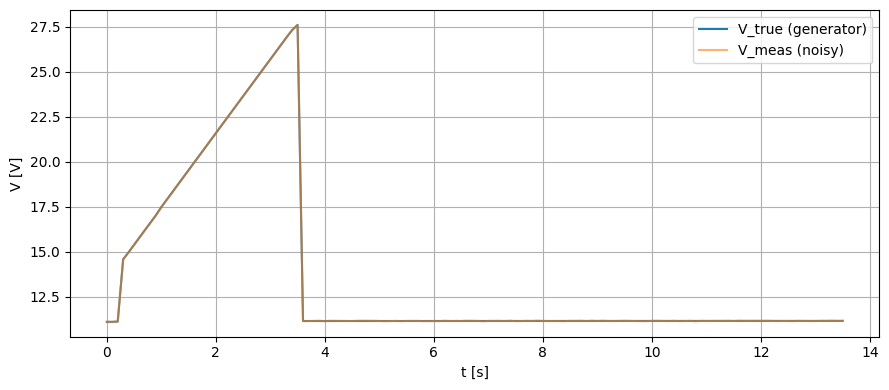

In [18]:
CFG = Config()
SIM_T_END = 10000.0
DT = 0.1
T = np.arange(0.0, SIM_T_END + DT, DT)
CFG.T_end = float(T[-1])

x0 = make_x0(CFG, theta_n0=0.2, theta_p0=0.9, ce0=0.0)
I_const = 2.0

theta_true = theta_from_cfg(CFG)
V_true = simulate_pack_voltage_theta_np(theta_true, T, I_const, x0, CFG)

# add some measurement noise
rng = np.random.default_rng(0)
V_meas = V_true + 0.01 * rng.standard_normal(len(T))

plt.figure(figsize=(9,4))
plt.plot(T, V_true, label="V_true (generator)")
plt.plot(T, V_meas, alpha=0.6, label="V_meas (noisy)")
plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


In [19]:
# convenient fixed indices for JAX
IDX_CP_SURF = IDX["cp_surf"]
IDX_CN_SURF = IDX["cn_surf"]
IDX_CE_LEFT = IDX["ce_left"]
IDX_CE_RIGHT = IDX["ce_right"]

def AB_from_theta_jax(theta):
    """
    theta: (24,) jnp array -> A(14x14), B(14x1)
    Mirrors AB_from_theta_np but in JAX style.
    """
    t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11 = theta[:11]

    A = jnp.zeros((14,14))

    # anode block
    A = A.at[0,0].set(t1); A = A.at[0,1].set(t1)
    A = A.at[1,0].set(t1); A = A.at[1,1].set(t1); A = A.at[1,2].set(t1)
    A = A.at[2,1].set(t1); A = A.at[2,2].set(t1); A = A.at[2,3].set(t1)
    A = A.at[3,2].set(t1); A = A.at[3,3].set(t1)

    # cathode block
    A = A.at[4,4].set(t2); A = A.at[4,5].set(t2)
    A = A.at[5,4].set(t2); A = A.at[5,5].set(t2); A = A.at[5,6].set(t2)
    A = A.at[6,5].set(t2); A = A.at[6,6].set(t2); A = A.at[6,7].set(t2)
    A = A.at[7,6].set(t2); A = A.at[7,7].set(t2)

    # electrolyte tri-diagonal
    A = A.at[8,8].set(t3);          A = A.at[8,9].set(t3)
    A = A.at[9,8].set(t3);          A = A.at[9,9].set(t3+t4);   A = A.at[9,10].set(t4)
    A = A.at[10,9].set(t4);         A = A.at[10,10].set(t4+t5); A = A.at[10,11].set(t5)
    A = A.at[11,10].set(t5);        A = A.at[11,11].set(t5+t6); A = A.at[11,12].set(t6)
    A = A.at[12,11].set(t6);        A = A.at[12,12].set(t6+t7); A = A.at[12,13].set(t7)
    A = A.at[13,12].set(t7);        A = A.at[13,13].set(t7)

    # B
    B = jnp.zeros((14,1))
    B = B.at[3,0].set(t8)
    B = B.at[7,0].set(t9)
    B = B.at[8,0].set(t10); B = B.at[9,0].set(t10)
    B = B.at[12,0].set(t11); B = B.at[13,0].set(t11)
    return A, B


In [20]:
# capture constants from CFG into a simple namespace-like object
class CfgJax:
    pass

CFG_JAX = CfgJax()
CFG_JAX.csn_max = CFG.csn_max
CFG_JAX.csp_max = CFG.csp_max
CFG_JAX.ce0     = CFG.ce0
CFG_JAX.N_series = CFG.N_series
CFG_JAX.ce_is_deviation = CFG.ce_is_deviation

def voltage_from_state_theta_jax(x, u, theta):
    """
    x: (14,), u: (1,), theta: (24,)
    Returns pack voltage (scalar) in JAX.
    """
    t12,t13,t14,t15 = theta[11:15]
    t16,t17,t18,t19 = theta[15:19]
    t20,t21,t22,t23,t24 = theta[19:24]

    I = u[0]

    xp = jnp.clip(x[IDX_CP_SURF] / CFG_JAX.csp_max, 1e-9, 1-1e-9)
    xn = jnp.clip(x[IDX_CN_SURF] / CFG_JAX.csn_max, 1e-9, 1-1e-9)

    ceL_raw = x[IDX_CE_LEFT]
    ceR_raw = x[IDX_CE_RIGHT]
    if CFG_JAX.ce_is_deviation:
        ceL = CFG_JAX.ce0 + ceL_raw
        ceR = CFG_JAX.ce0 + ceR_raw
    else:
        ceL = ceL_raw
        ceR = ceR_raw

    ceL = jnp.maximum(ceL, 1e-12)
    ceR = jnp.maximum(ceR, 1e-12)
    ce_avg = 0.5*(ceL + ceR)

    # OCV
    Up = t12 + t13 * jnp.tanh((xp - t14) / jnp.maximum(t15, 1e-6))
    Un = t16 + t17 * (1.0 / (1.0 + jnp.exp(-(xn - t18) / jnp.maximum(t19, 1e-6))))

    # BV
    s_p = jnp.sqrt(jnp.maximum(1e-16, ce_avg)) * jnp.sqrt(jnp.maximum(1e-16, xp*(1-xp)))
    s_n = jnp.sqrt(jnp.maximum(1e-16, ce_avg)) * jnp.sqrt(jnp.maximum(1e-16, xn*(1-xn)))
    den_p = jnp.maximum(1e-16, t20 * s_p)
    den_n = jnp.maximum(1e-16, t21 * s_n)
    VBV = t24 * (jnp.arcsinh(I/den_p) - jnp.arcsinh(I/den_n))

    # electrolyte log
    Ve = t22 * jnp.log(ceR/ceL)

    # ohmic
    Vohm = -I * t23

    V_cell = (Up - Un) + VBV + Ve + Vohm
    V_pack = CFG_JAX.N_series * V_cell
    return V_pack


In [21]:
nx, ny, nu = 14, 1, 1
dt = DT  # same sampling as synthetic data

def state_fcn(x, u, params):
    """
    x: (nx,), u: (nu,), params: list/tuple [theta]
    x_{k+1} = x_k + dt * (A(theta)x_k + B(theta)u_k)
    """
    (theta,) = params
    A, B = AB_from_theta_jax(theta)
    xdot = A @ x + B[:,0] * u[0]
    return x + dt * xdot

def output_fcn(x, u, params):
    (theta,) = params
    V_pack = voltage_from_state_theta_jax(x, u, theta)
    return jnp.array([V_pack])  # shape (1,)


In [22]:
model = Model(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)


In [23]:
# Inputs: constant current I_const as a column vector
U = np.full((len(T), 1), I_const)
Y = V_meas.reshape(-1, 1)

# Scale data (good practice)
Ys, ymean, ygain = standard_scale(Y)
Us, umean, ugain = standard_scale(U)


In [24]:
theta0 = theta_true.copy()
theta0_pert = theta0 * (1.0 + 0.05*np.random.randn(*theta0.shape))  # 5% noise

# Initialize model parameters
model.init(params=[jnp.array(theta0_pert)])


In [25]:
# Small L2 regularization on theta and x0
model.loss(rho_x0=1e-4, rho_th=1e-4)

# First a few Adam steps, then L-BFGS
model.optimization(adam_epochs=500, lbfgs_epochs=1000)

# Fit
model.fit(Ys, Us)


  0%|                        |

Solving NLP with Adam (38 optimization variables) ...


100%|████████████████████████|

UnboundLocalError: cannot access local variable 'zbest' where it is not associated with a value

In [ ]:
# Predict on training data
Yshat, Xhat = model.predict(model.x0, Us)
Yhat = unscale(Yshat, ymean, ygain)

# Compute R2
R2_train, _, msg = compute_scores(Y, Yhat, None, None, fit='R2')
print(msg)


In [ ]:
plt.figure(figsize=(9,4))
plt.plot(T, Y, label="V_meas (noisy)")
plt.plot(T, Yhat, '--', label="V_hat (jax-sysid)")
plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
theta_hat = np.array(model.params[0])  # model.params is a list [theta]

print("True θ (first 10):\n", theta_true[:10])
print("Hat  θ (first 10):\n", theta_hat[:10])

theta_diff = theta_hat - theta_true
rel_err = np.linalg.norm(theta_diff)/ (np.linalg.norm(theta_true) + 1e-18)
print("‖θ_hat - θ_true‖ / ‖θ_true‖ =", rel_err)


Evaluating models...

Scores:
Model 0: R2 = 0.3330987692624497
Model 1: R2 = 0.3330994749490148
Model 2: R2 = 0.33310503487151866
Model 3: R2 = 0.33309933590957497
Model 4: R2 = 0.33309418415889763
Model 5: R2 = 0.33309431850520405
Model 6: R2 = 0.3331089838758697
Model 7: R2 = 0.3331474202384401
Best model: 7, score: 0.3331474202384401
R2 score:  training =  99.9442, test =  99.9605


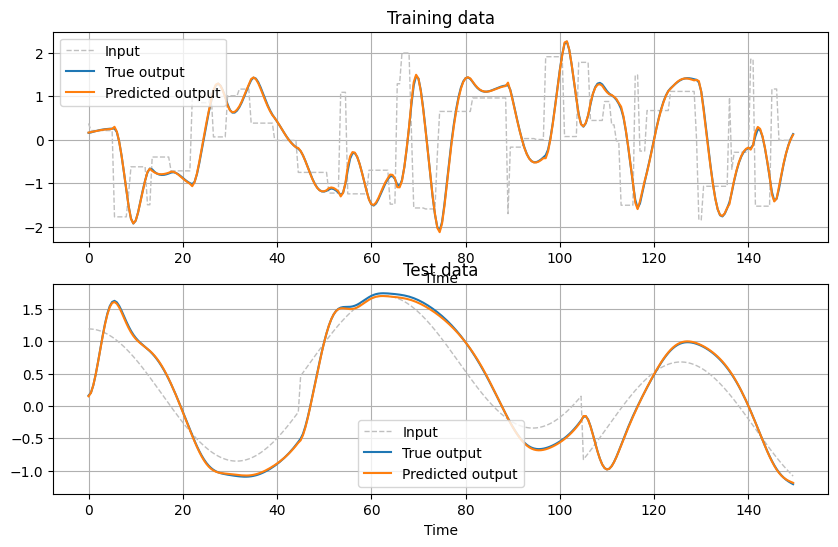

In [1]:
"""
jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

Nonlinear system identification example in continuous time using a recurrent neural network model

            dx(t)/dt = fx(x(t),u(t),t)
                y(t) = fy(x(t),u(t),t)

(C) 2024 A. Bemporad, December 22, 2024
"""

from jax_sysid.utils import standard_scale, compute_scores
from jax_sysid.models import CTModel
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import diffrax

jax.config.update('jax_platform_name', 'cpu')
if not jax.config.jax_enable_x64:
    jax.config.update("jax_enable_x64", True)  # Enable 64-bit computations

seed = 3  # for reproducibility of results
np.random.seed(seed)

nx = 2  # number of states
ny = 1  # number of outputs
nu = 1  # number of inputs

# Data generation
Ts = 0.5  # sample time of control input (time units)
Tstop = 150 # total excitation time (time units)
T_train = np.arange(0.,Tstop,Ts)
#U_train = np.sin(0.002*T_train**2)  # input signal
u0=4.*np.random.rand()-2.
U_train = np.empty(T_train.shape).reshape(-1,1)
for i in range(T_train.size):
    if np.random.randn()>0.95:
        u0=4.*np.random.rand()-2.
    U_train[i] = u0
x0_train = np.array([0.,0.])  # initial state

Ts=0.5
Tstop = 150 # total excitation time (time units)
T_test = np.arange(0.,Tstop,Ts)
U_test = (np.cos(0.1*T_test)+.5*(T_test>=Tstop*.3)-1.*(T_test>=Tstop*.7)).reshape(-1,1) # input signal
x0_test = np.array([0.,0.])  # initial state

# Continuous time system:
# yddot = -0.5*ydot + 0.3*u - 0.2*y - 0.1*y**3 --> x1dot = x2
#                                                  x2dot = -0.5*x2 + 0.3*u - 0.2*x1 - 0.1*x1**3
def truesystem(x0, U, T):
    # system generating the training and test dataset    
    Tc, Uc = diffrax.rectilinear_interpolation(T,U.reshape(-1))
    input_fcn = diffrax.LinearInterpolation(ts=Tc, ys=Uc)    

    @jax.jit
    def state_fcn_true(t, x, args):
        # state update function xdot = state_fcn(t,x,u)
        return jnp.array([x[1], -0.5*x[1] + 0.3*input_fcn.evaluate(t) - 0.2*x[0] - 0.1*x[0]**3])

    @jax.jit
    def output_fcn_(t, x, args):
        return x[0]
    output_fcn_true = jax.jit(jax.vmap(output_fcn_, in_axes=(0,0,None)))

    @jax.jit
    def solve(x0):
        term = diffrax.ODETerm(state_fcn_true)
        solver = diffrax.Dopri5()
        t0 = T[0]
        t1 = T[-1]
        dt0 = (T[1]-T[0])/10.
        saveat = diffrax.SaveAt(ts=jnp.array(T))
        #saveat = SaveAt(ts=jnp.arange(t0,t1,dt0))
        sol = diffrax.diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt0, y0=x0, args=None, saveat=saveat, max_steps=100000)
        return sol
    
    sol = solve(x0)
    X = sol.ys
    Y = output_fcn_true(sol.ts, X, None)
    return Y, X

Y_train, _ = truesystem(x0_train, U_train, T_train)

Ys_train, ymean, ygain = standard_scale(Y_train)
Us_train, umean, ugain = standard_scale(U_train)

Y_test, _ = truesystem(x0_test, U_test, T_test)
Ys_test = (Y_test-ymean)*ygain
Us_test = (U_test-umean)*ugain

Ys_train = Ys_train.reshape(-1,1)
Ys_test = Ys_test.reshape(-1,1)

# Perform system identification
def activation(x):
    return 1. / (1. + jnp.exp(-x))
    #return jnp.maximum(0., x)

@jax.jit
def state_fcn(x, u, t, params):
    # This computes dx/dt = f(x,u) for continuous-time systems
    A, B, C, W1, W2, W3, b1, b2 = params
    return A@x+B@u+W3@activation(W1@x+W2@u+b1)+b2

@jax.jit
def output_fcn(x, u, t, params):
    C = params[2]
    return C@x

nnx = 10  # number of hidden neurons in state-update function

def init_fcn(seed):
    np.random.seed(seed)
    A = -np.eye(nx) # start with a stable linear system
    B = 0.1*np.random.randn(nx, nu)
    C = 0.1*np.random.randn(ny, nx)
    W1 = 0.1*np.random.randn(nnx, nx)
    W2 = 0.5*np.random.randn(nnx, nu)
    W3 = 0.5*np.random.randn(nx, nnx)
    b1 = np.zeros(nnx)
    b2 = np.zeros(nx)
    return [A, B, C, W1, W2, W3, b1, b2]

# initialize model coefficients
model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)
model.integration_options(ode_solver=diffrax.Heun())
model.init(params=init_fcn(seed=1))
# L2-regularization on initial state and model coefficients
model.loss(rho_x0=1.e-4, rho_th=1.e-4, train_x0=True) # default: integral of squared output prediction errors
# number of epochs for Adam and L-BFGS-B optimization
model.optimization(adam_epochs=100, lbfgs_epochs=2000, adam_eta=0.1)

# Fit model to training data
# model.fit(Ys_train, Us_train, T_train)

# Train from different initializations:
models = model.parallel_fit(Ys_train, Us_train, T_train, init_fcn=init_fcn)
R2 = model.find_best_model(models, Ys_train, Us_train, T_train)

x0_train=model.learn_x0(Us_train, Ys_train, T_train)
Yshat_train, Xhat_train = model.predict(x0_train, Us_train, T_train)

x0_test=model.learn_x0(Us_test, Ys_test, T_test)
T_test = np.arange(0.,T_test.size*Ts,Ts)
Yshat_test, _ = model.predict(x0_test, Us_test, T_test)

# Compute scores
R2_train, R2_test, msg = compute_scores(Ys_train, Yshat_train, Ys_test, Yshat_test)
print(msg)

# Plot results
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(T_train, Us_train, color=[.75,.75,.75], linestyle='--', linewidth=1., label='Input')
ax[0].plot(T_train, Ys_train, label='True output')
ax[0].plot(T_train, Yshat_train, label='Predicted output')
ax[0].set_title('Training data')
ax[0].legend()
ax[0].grid()
ax[0].set_xlabel('Time')
ax[1].plot(T_test, Us_test, color=[.75,.75,.75], linestyle='--', linewidth=1., label='Input')
ax[1].plot(T_test, Ys_test, label='True output')
ax[1].plot(T_test, Yshat_test, label='Predicted output')
ax[1].set_title('Test data')
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Time')

plt.show()


Solving NLP with L-BFGS (87 optimization variables) ...
L-BFGS-B done in 1840 iterations.
Elapsed time: 12.806060791015625 s

RTS smoothing, epoch:   1/ 10, MSE loss =  0.003487

RTS smoothing, epoch:   2/ 10, MSE loss =  0.002293

RTS smoothing, epoch:   3/ 10, MSE loss =  0.002248

RTS smoothing, epoch:   4/ 10, MSE loss =  0.002230

RTS smoothing, epoch:   5/ 10, MSE loss =  0.002218

RTS smoothing, epoch:   6/ 10, MSE loss =  0.002209

RTS smoothing, epoch:   7/ 10, MSE loss =  0.002202

RTS smoothing, epoch:   8/ 10, MSE loss =  0.002195

RTS smoothing, epoch:   9/ 10, MSE loss =  0.002190

RTS smoothing, epoch:  10/ 10, MSE loss =  0.002187
R2 score:  training =  99.7893, test =  99.7906


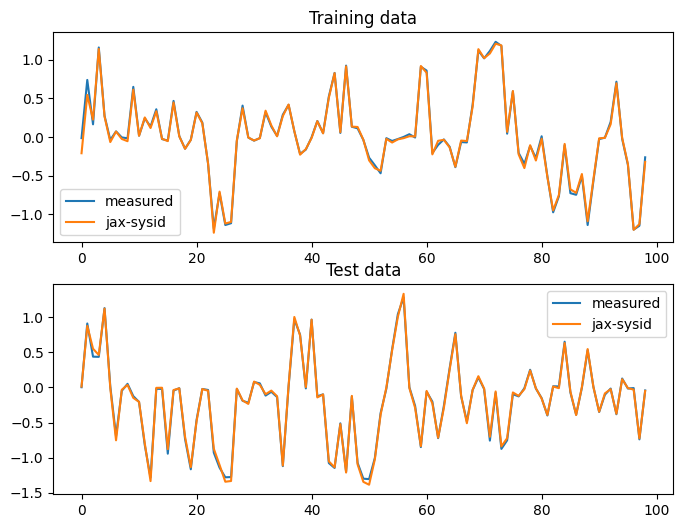

In [2]:
"""
jax-sysid: A Python package for linear and nonlinear system identification and nonlinear regression using Jax.

Nonlinear system identification example using custom residual recurrent neural network model

            x(k+1) = A*x(k) + B*u(k) + fx(x(k),u(k))
              y(k) = C*x(k) + fy(x(k),u(k))

(C) 2024 A. Bemporad, March 6, 2024
"""

import matplotlib.pyplot as plt
from jax_sysid.utils import standard_scale, unscale, compute_scores
from jax_sysid.models import Model
import jax
import jax.numpy as jnp
import numpy as np

plotfigs = True  # set to True to plot figures

# Data generation
seed = 3  # for reproducibility of results
np.random.seed(seed)

nx = 3  # number of states
ny = 1  # number of outputs
nu = 1  # number of inputs

N_train = 10000  # number of training data
N_test = 1000  # number of test data
Ts = 1.  # sample time

B = np.random.randn(nx, nu)
C = np.random.randn(ny, nx)


def truesystem(x0, U, D, qx, qy):
    # system generating the training and test dataset
    N_train = U.shape[0]
    x = x0.copy()
    Y = np.empty((N_train, ny))
    X = np.empty((N_train, nx))
    for k in range(N_train):
        X[k] = x
        Y[k] = np.arctan(C @ x**3) + qy * D[k,nx:]
        x[0] = .5*np.sin(X[k,0]) + B[0, :]@U[k] * \
            np.cos(X[k,1]/2.) + qx * D[k,0]
        x[1] = .6*np.sin(X[k,0]+X[k,2]) + B[1, :]@U[k] * \
            np.arctan(X[k,0]+X[k,1]) + qx * D[k,1]
        x[2] = .4*np.exp(-X[k,1]) + B[2, :]@U[k] * \
            np.sin(-X[k,0]/2.) + qx * D[k,2]
    return Y, X

qy = 0.01  # output noise std
qx = 0.01  # process noise std
U_train = np.random.rand(N_train, nu)-0.5
D_train = np.random.randn(N_train, nx+ny)
x0_train = np.zeros(nx)
Y_train, _ = truesystem(x0_train, U_train, D_train, qx, qy)

Ys_train, ymean, ygain = standard_scale(Y_train)
Us_train, umean, ugain = standard_scale(U_train)

U_test = np.random.rand(N_test, nu)-0.5
D_test = np.random.randn(N_test, nx+ny)
x0_test = np.zeros(nx)
Y_test, _ = truesystem(x0_test, U_test, D_test, qx, qy)
Ys_test = (Y_test-ymean)*ygain  # use same scaling as for training data
Us_test = (U_test-umean)*ugain

# Perform system identification
jax.config.update('jax_platform_name', 'cpu')
if not jax.config.jax_enable_x64:
    jax.config.update("jax_enable_x64", True)  # Enable 64-bit computations


def sigmoid(x):
    return 1. / (1. + jnp.exp(-x))


@jax.jit
def state_fcn(x, u, params):
    A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
    return A@x+B@u+W3@sigmoid(W1@x+W2@u+b1)+b2


@jax.jit
def output_fcn(x, u, params):
    A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
    return C@x+W5@sigmoid(W4@x+b3)+b4


model = Model(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

nnx = 5  # number of hidden neurons in state-update function
nny = 5  # number of hidden neurons in output function

A = 0.5*np.eye(nx)
B = 0.1*np.random.randn(nx, nu)
C = 0.1*np.random.randn(ny, nx)
W1 = 0.1*np.random.randn(nnx, nx)
W2 = 0.5*np.random.randn(nnx, nu)
W3 = 0.5*np.random.randn(nx, nnx)
b1 = np.zeros(nnx)
b2 = np.zeros(nx)
W4 = 0.5*np.random.randn(nny, nx)
W5 = 0.5*np.random.randn(ny, nny)
b3 = np.zeros(nny)
b4 = np.zeros(ny)
# initialize model coefficients
model.init(params=[A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4])
# L2-regularization on initial state and model coefficients
model.loss(rho_x0=1.e-4, rho_th=1.e-4)
# number of epochs for Adam and L-BFGS-B optimization
model.optimization(adam_epochs=0, lbfgs_epochs=2000)
model.fit(Ys_train, Us_train)
t0 = model.t_solve

print(f"Elapsed time: {t0} s")
Yshat_train, _ = model.predict(model.x0, Us_train)
Yhat_train = unscale(Yshat_train, ymean, ygain)

# use RTS Smoother to learn x0
x0_test = model.learn_x0(Us_test, Ys_test, RTS_epochs=10)
Yshat_test, _ = model.predict(x0_test, Us_test)
Yhat_test = unscale(Yshat_test, ymean, ygain)
R2, R2_test, msg = compute_scores(
    Y_train, Yhat_train, Y_test, Yhat_test, fit='R2')

print(msg)
# print(model.sparsity_analysis()) # only useful when tau_th>0

if plotfigs:
    T_train = np.arange(N_train)*Ts
    T_test = np.arange(N_test)*Ts
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(T_train[0:99], Y_train[0:99, 0], label='measured')
    ax[0].plot(T_train[0:99], Yhat_train[0:99, 0], label='jax-sysid')
    ax[0].legend()
    ax[0].set_title('Training data')
    ax[1].plot(T_test[0:99], Y_test[0:99, 0], label='measured')
    ax[1].plot(T_test[0:99], Yhat_test[0:99, 0], label='jax-sysid')
    ax[1].legend()
    ax[1].set_title('Test data')
    plt.show()
